<a href="https://colab.research.google.com/github/Melo95/ML_course_Pavia_23/blob/v2/Exercises_custom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install torch geometric
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch_cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.0.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 12.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy()) #multidimentional space is compressed in 2 dimentions so that we can visualize it

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [3]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures()) #normalizeFeatures is scaling in order to normalize

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...
Done!



Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [23]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GATConv


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads1, heads2):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dataset.num_features, hidden_channels, heads1)
        self.conv2 = GATConv(hidden_channels*heads1, dataset.num_classes, heads2)
        

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.6, training=self.training)
        return x

model = GAT(hidden_channels=8, heads1=8, heads2 = 1)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc


for epoch in range(1, 201):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=1)
)
Epoch: 001, Loss: 1.9456, Val: 0.1840, Test: 0.1540
Epoch: 002, Loss: 1.9439, Val: 0.1620, Test: 0.1490
Epoch: 003, Loss: 1.9390, Val: 0.1920, Test: 0.1710
Epoch: 004, Loss: 1.9343, Val: 0.2600, Test: 0.2380
Epoch: 005, Loss: 1.9328, Val: 0.3440, Test: 0.3220
Epoch: 006, Loss: 1.9349, Val: 0.3520, Test: 0.3530
Epoch: 007, Loss: 1.9193, Val: 0.4560, Test: 0.4650
Epoch: 008, Loss: 1.9281, Val: 0.4360, Test: 0.4440
Epoch: 009, Loss: 1.9082, Val: 0.4760, Test: 0.4930
Epoch: 010, Loss: 1.9088, Val: 0.4880, Test: 0.4990
Epoch: 011, Loss: 1.9120, Val: 0.5420, Test: 0.5310
Epoch: 012, Loss: 1.9028, Val: 0.5540, Test: 0.5650
Epoch: 013, Loss: 1.8728, Val: 0.5420, Test: 0.5470
Epoch: 014, Loss: 1.8814, Val: 0.5240, Test: 0.5330
Epoch: 015, Loss: 1.8546, Val: 0.5200, Test: 0.5220
Epoch: 016, Loss: 1.8912, Val: 0.5780, Test: 0.5620
Epoch: 017, Loss: 1.8729, Val: 0.6000, Test: 0.5950
Epoch: 018, Loss: 1.8417, Val: 0.6180

In [26]:
test_acc = test(data.test_mask)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7060


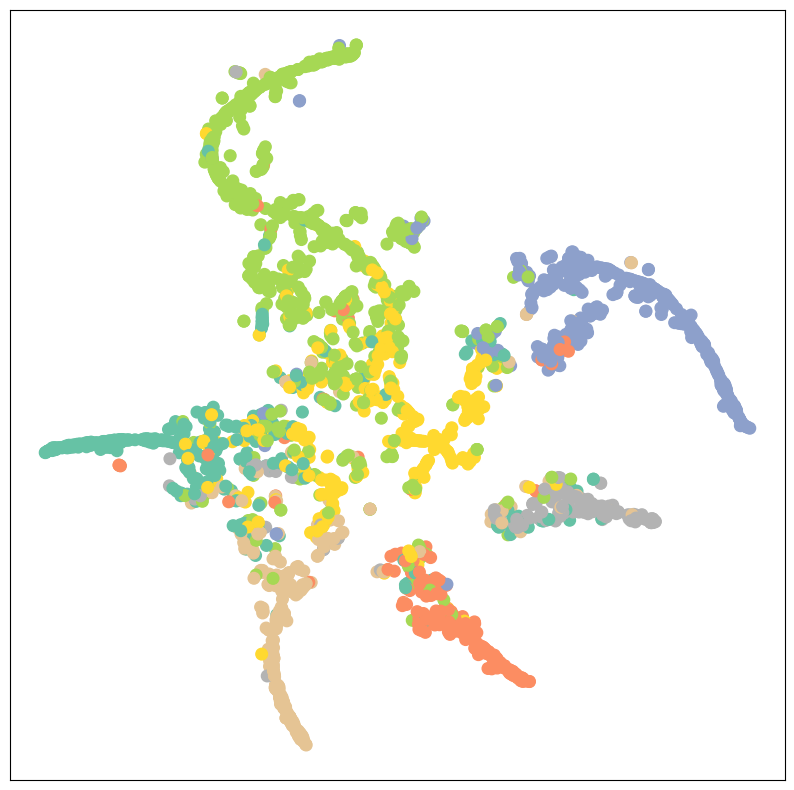

In [27]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)